In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import aesara.tensor.subtensor as st
from itertools import combinations

%load_ext lab_black
%load_ext watermark

# Simvastatin

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [Unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.txt).


Associated lecture videos: Unit 8 lessons 8 and 9

## Problem statement

In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth.
The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations: $10^{-9}$, $10^{-8}$ and $10^{-7}$ M, cells were treated with the drug.
These cells were plated on four, 24 well plates with each well plate having a different treatment.
To test for osteoblastic differentiation an assay, pNPP, was used to test for alkaline phosphatase activity.
The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like.
This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.


## Notes: 

A good explanation of stz constraints:
https://stats.stackexchange.com/questions/257778/sum-to-zero-constraint-in-one-way-anova

In [2]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")
data

,apa,conc,time
0,0.062,1,1
1,0.517,1,1
2,0.261,1,1
3,0.154,1,1
4,0.071,2,1
...,...,...,...
91,0.085,3,6
92,0.290,4,6
93,0.090,4,6
94,0.518,4,6


In [3]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "time": time, "id": data.index}

conc_idx, time_idx, coords

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], dtype=int64),
 {'conc': Int64Index([1, 2, 3, 4], dtype='int64'),
  'time': Int64Index([1, 2, 3, 4, 5, 6], dtype='int64'),
  'id': RangeIndex(start=0, stop=96, step=1)})

## Model 1 with sum-to-zero constraints

In [4]:
def differences(var, index):
    """Calculate differences between levels with names like "alpha[low] - alpha[high]".

    var: aesara.tensor.var.TensorVariable
    index: pandas.Index
    """
    name = var.name
    for i, j in combinations(range(index.size), 2):
        a, b = index[i], index[j]
        pm.Deterministic(f"{name}[{a}] - {name}[{b}]", var[i] - var[j])


with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # sum-to-zero constraints
    # sets the first element of a dimension to the negative sum of the rest
    sst_1d_0 = lambda var: st.set_subtensor(var[0], -var[1:].sum(axis=0))
    sst_2d_0 = lambda var: st.set_subtensor(var[0, :], -var[1:, :].sum(axis=0))
    sst_2d_1 = lambda var: st.set_subtensor(var[:, 0], -var[:, 1:].sum(axis=1))

    alpha = pm.Deterministic("alpha", sst_1d_0(_alpha), dims="conc")
    beta = pm.Deterministic("beta", sst_1d_0(_beta), dims="time")
    _alphabeta = sst_2d_1(_alphabeta)
    alphabeta = pm.Deterministic(
        "alphabeta", sst_2d_0(_alphabeta), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    # calculate differences between levels with appropriate names
    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


In [5]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.239,0.025,0.191,0.284
tau,17.164,2.864,12.066,22.693
sigma,0.244,0.021,0.208,0.285
alpha[1],0.049,0.044,-0.030,0.135
alpha[2],0.069,0.043,-0.015,0.150
alpha[3],-0.075,0.043,-0.162,-0.001
alpha[4],-0.043,0.044,-0.127,0.039
beta[1],0.046,0.056,-0.058,0.152
beta[2],-0.150,0.056,-0.255,-0.046
beta[3],-0.018,0.056,-0.123,0.087


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

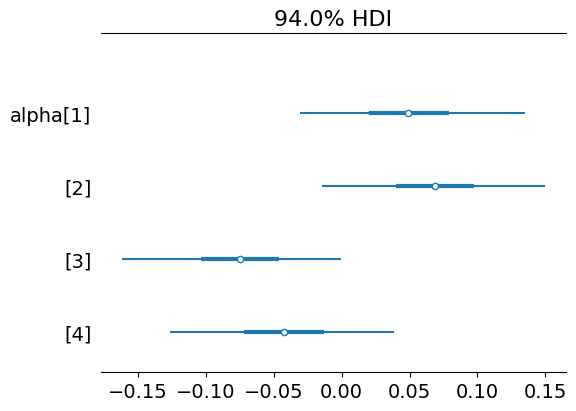

In [6]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

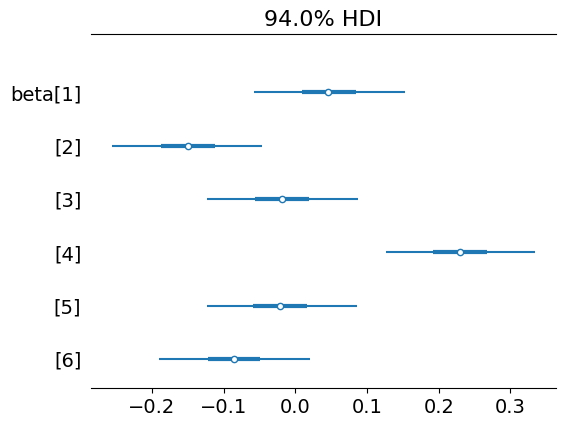

In [7]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

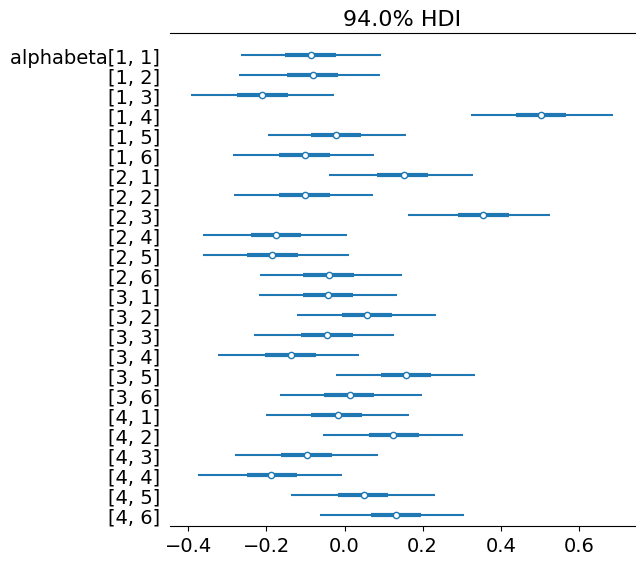

In [8]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

In [9]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints: sets the first element of a dimension to zero
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0), dims="conc")
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0), dims="time")
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic(
        "alphabeta", st.set_subtensor(_alphabeta[0, :], 0), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


In [10]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.245,0.124,0.023,0.489
tau,17.126,2.857,11.773,22.433
sigma,0.244,0.021,0.205,0.282
alpha[1],0.000,0.000,0.000,0.000
alpha[2],0.259,0.175,-0.072,0.590
alpha[3],-0.079,0.174,-0.404,0.255
alpha[4],-0.022,0.172,-0.340,0.304
beta[1],0.000,0.000,0.000,0.000
beta[2],-0.187,0.177,-0.515,0.156
beta[3],-0.185,0.176,-0.512,0.145


In [11]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Wed Dec 07 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.7.0

aesara: 2.8.7
aeppl : 0.0.38

arviz : 0.14.0
sys   : 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
pandas: 1.5.2
numpy : 1.23.5
pymc  : 4.4.0
aesara: 2.8.7

